# Deep Learning Lab Assignment 4

    Ayush Abrol B20AIA052

---

## Building an RNN architecture to classify names based on their language. (The dataset includes the names of people in 18 different languages)

### Importing necessary libraries and modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

### Importing data preprocessing libraries

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

### Reading the text data files

In [3]:
def findFiles(path): 
    return glob.glob(path)

In [4]:
print(findFiles('data/names/*.txt'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


### Getting all the unique characters in the dataset

In [5]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print("All the letters are: ", all_letters)
print("Number of letters are: ", n_letters)

All the letters are:  abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Number of letters are:  57


### Converting the Unicode characters to ASCII

In [6]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(f"Unicode to ASCII for 'Ślusàrski': {unicodeToAscii('Ślusàrski')}")

Unicode to ASCII for 'Ślusàrski': Slusarski


### Creating a dictionary to map each class(country name) to the list of names in that class

In [7]:
category_lines = {}
all_categories = []

In [8]:
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]                                           

In [9]:
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
num_classes = n_categories
print("All the categories are: ", all_categories)
print("Number of categories are: ", n_categories)

All the categories are:  ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
Number of categories are:  18


### Obtaining the number of of samples in each class

In [10]:
total_names = 0
for i in range(num_classes):
    print("First 10 names in category", all_categories[i], "are", category_lines[all_categories[i]][:10], "...")
    print("Number of names in category", all_categories[i], "is", len(category_lines[all_categories[i]]))
    total_names += len(category_lines[all_categories[i]])
print("Total number of names are: ", total_names)

First 10 names in category Arabic are ['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari', 'Maalouf', 'Gerges', 'Naifeh', 'Guirguis', 'Baba'] ...
Number of names in category Arabic is 2000
First 10 names in category Chinese are ['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao'] ...
Number of names in category Chinese is 268
First 10 names in category Czech are ['Abl', 'Adsit', 'Ajdrna', 'Alt', 'Antonowitsch', 'Antonowitz', 'Bacon', 'Ballalatak', 'Ballaltick', 'Bartonova'] ...
Number of names in category Czech is 519
First 10 names in category Dutch are ['Aalsburg', 'Aalst', 'Aarle', 'Achteren', 'Achthoven', 'Adrichem', 'Aggelen', 'Agteren', 'Agthoven', 'Akkeren'] ...
Number of names in category Dutch is 297
First 10 names in category English are ['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel', 'Abraham', 'Abrahams', 'Abrams', 'Ackary', 'Ackroyd'] ...
Number of names in category English is 3668
First 10 names in category French are ['Abel', 'Abraham', 'Adam', 'Albert', '

### To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

### To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>

In [11]:
def letterToIndex(letter):
    return all_letters.find(letter)

# Turning a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turning a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

### Examples of a one-hot vector

In [12]:
print(letterToTensor('a'))

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [13]:
print(lineToTensor('ayush').size())
print(lineToTensor('ayush'))

torch.Size([5, 1, 57])
tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        

### Creating an encoded dictionary to map each class(country name) to the list of encoded names(tensor form) in that class

In [14]:
encoded_category_lines = {}
for i in category_lines:
    # Convert the list of names into tensors of one-hot vectors
    encoded_category_lines[i] = [lineToTensor(name) for name in category_lines[i]]

In [15]:
print(category_lines['Italian'][1], "is encoded as", encoded_category_lines['Italian'][1])

Abatangelo is encoded as tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      

### Creating an empty dataset and an empty label list to store the encoded names and their corresponding labels

In [16]:
dataset = []
labels = []
print(dataset, labels)

[] []


### Encoding the labels

In [17]:
classes = {0 : 'Arabic', 1 : 'Chinese', 2 : 'Czech', 3 : 'Dutch', 4 : 'English', 5 : 'French', 6 : 'German', 7 : 'Greek', 8 : 'Irish', 9 : 'Italian', 10 : 'Japanese', 11 : 'Korean', 12 : 'Polish', 13 : 'Portuguese', 14 : 'Russian', 15 : 'Scottish', 16 : 'Spanish', 17 : 'Vietnamese'}

### Obtaining the shape of each encoded name

In [18]:
for i in range(num_classes):
    for j in range(len(encoded_category_lines[all_categories[i]])):
        print(category_lines[all_categories[i]][j],"---", encoded_category_lines[all_categories[i]][j].size())

Khoury --- torch.Size([6, 1, 57])
Nahas --- torch.Size([5, 1, 57])
Daher --- torch.Size([5, 1, 57])
Gerges --- torch.Size([6, 1, 57])
Nazari --- torch.Size([6, 1, 57])
Maalouf --- torch.Size([7, 1, 57])
Gerges --- torch.Size([6, 1, 57])
Naifeh --- torch.Size([6, 1, 57])
Guirguis --- torch.Size([8, 1, 57])
Baba --- torch.Size([4, 1, 57])
Sabbagh --- torch.Size([7, 1, 57])
Attia --- torch.Size([5, 1, 57])
Tahan --- torch.Size([5, 1, 57])
Haddad --- torch.Size([6, 1, 57])
Aswad --- torch.Size([5, 1, 57])
Najjar --- torch.Size([6, 1, 57])
Dagher --- torch.Size([6, 1, 57])
Maloof --- torch.Size([6, 1, 57])
Isa --- torch.Size([3, 1, 57])
Asghar --- torch.Size([6, 1, 57])
Nader --- torch.Size([5, 1, 57])
Gaber --- torch.Size([5, 1, 57])
Abboud --- torch.Size([6, 1, 57])
Maalouf --- torch.Size([7, 1, 57])
Zogby --- torch.Size([5, 1, 57])
Srour --- torch.Size([5, 1, 57])
Bahar --- torch.Size([5, 1, 57])
Mustafa --- torch.Size([7, 1, 57])
Hanania --- torch.Size([7, 1, 57])
Daher --- torch.Size([

### Appending the encoded names and their corresponding labels to the dataset and label list

In [19]:
for i in range(num_classes):
    for j in range(len(encoded_category_lines[all_categories[i]])):
        dataset.append(encoded_category_lines[all_categories[i]][j])
        labels.append(i)

### Final length of the dataset and label list

In [20]:
print("Length of dataset is: ", len(dataset))
print("Length of labels is: ", len(labels))

Length of dataset is:  20074
Length of labels is:  20074


### Splitting the dataset and label list into training, validation and testing sets

In [21]:
# Split the dataset into train, validation and test sets
train_data, val_data, train_labels, val_labels = train_test_split(dataset, labels, test_size=0.2, random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(val_data, val_labels, test_size=0.5, random_state=42)

print("Length of train_data is: ", len(train_data))
print("Length of train_labels is: ", len(train_labels))
print("Length of val_data is: ", len(val_data))
print("Length of val_labels is: ", len(val_labels))
print("Length of test_data is: ", len(test_data))
print("Length of test_labels is: ", len(test_labels))

Length of train_data is:  16059
Length of train_labels is:  16059
Length of val_data is:  2007
Length of val_labels is:  2007
Length of test_data is:  2008
Length of test_labels is:  2008


### Setting the environment as GPU

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Building the RNN architecture as mentioned in the question

In [117]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

### Instantiating the RNN model with number of hidden units as 128

In [118]:
rnn = RNN(n_letters, 128, n_categories).to(device)

### Defining the loss as CrossEntropyLoss and the optimizer as Adam with learning rate as 0.0001

In [119]:
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
num_epochs = 20
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)

### Defining the training loop for the RNN model

In [120]:
def train_rnn(rnn, train_data, train_labels, num_epochs):
    train_losses = []
    train_acc = []
    val_losses = []
    val_acc = []
    for epoch in range(num_epochs):
        running_loss_train = 0.0
        correct_train = 0
        # cnt = 0
        for i in range(len(train_data)):
            input = train_data[i].to(device)
            target = torch.tensor([train_labels[i]], dtype=torch.long).to(device)
            hidden = rnn.initHidden().to(device)
            rnn.zero_grad()
            optimizer.zero_grad()
            for j in range(input.size()[0]):
                output, hidden = rnn(input[j], hidden)
            loss = criterion(output, target)
        
            loss.backward()
            optimizer.step()
            running_loss_train += loss.item()

            if torch.argmax(output) == target:
                correct_train += 1
        train_losses.append(running_loss_train/(len(train_data)))
        train_acc.append(correct_train/(len(train_data)))
        print("Epoch: %d Train Loss: %1.5f" % (epoch + 1, running_loss_train/(len(train_data))))
        print("Epoch: %d Train Accuracy: %1.5f" % (epoch + 1, correct_train/(len(train_data))))

        running_loss_val = 0.0
        correct_val = 0
        for i in range(len(val_data)):
            input_val = val_data[i].to(device)
            target_val = torch.tensor([val_labels[i]], dtype=torch.long).to(device)
            hidden_val = rnn.initHidden().to(device)
            for j in range(input_val.size()[0]):
                output_val, hidden_val = rnn(input_val[j], hidden_val)
            loss = criterion(output_val, target_val)
            running_loss_val += loss.item()
            if torch.argmax(output_val) == target_val:
                correct_val += 1

        val_losses.append(running_loss_val/(len(val_data)))
        val_acc.append(correct_val/(len(val_data)))
        print("Epoch: %d Val Loss: %1.5f" % (epoch + 1, running_loss_val/(len(val_data))))
        print("Epoch: %d Val Accuracy: %1.5f" % (epoch + 1, correct_val/(len(val_data))))

    return train_losses, train_acc, val_losses, val_acc


### Training the RNN model on the training set with 20 epochs and validating it on the validation set

In [121]:
train_losses_rnn, train_acc_rnn, val_losses_rnn, val_acc_rnn = train_rnn(rnn, train_data, train_labels, num_epochs)

Epoch: 1 Train Loss: 2.48421
Epoch: 1 Train Accuracy: 0.50371
Epoch: 1 Val Loss: 2.46382
Epoch: 1 Val Accuracy: 0.53114
Epoch: 2 Train Loss: 2.44001
Epoch: 2 Train Accuracy: 0.55408
Epoch: 2 Val Loss: 2.43143
Epoch: 2 Val Accuracy: 0.56502
Epoch: 3 Train Loss: 2.39980
Epoch: 3 Train Accuracy: 0.59649
Epoch: 3 Val Loss: 2.39597
Epoch: 3 Val Accuracy: 0.59791
Epoch: 4 Train Loss: 2.37032
Epoch: 4 Train Accuracy: 0.62706
Epoch: 4 Val Loss: 2.37339
Epoch: 4 Val Accuracy: 0.61834
Epoch: 5 Train Loss: 2.35248
Epoch: 5 Train Accuracy: 0.64412
Epoch: 5 Val Loss: 2.36196
Epoch: 5 Val Accuracy: 0.62980
Epoch: 6 Train Loss: 2.33936
Epoch: 6 Train Accuracy: 0.65583
Epoch: 6 Val Loss: 2.34809
Epoch: 6 Val Accuracy: 0.64275
Epoch: 7 Train Loss: 2.33027
Epoch: 7 Train Accuracy: 0.66368
Epoch: 7 Val Loss: 2.33992
Epoch: 7 Val Accuracy: 0.64723
Epoch: 8 Train Loss: 2.32330
Epoch: 8 Train Accuracy: 0.66966
Epoch: 8 Val Loss: 2.33462
Epoch: 8 Val Accuracy: 0.65072
Epoch: 9 Train Loss: 2.31889
Epoch: 9 Tr

### Saving the trained RNN model with learning rate as 0.0001

In [127]:
# Save the model
torch.save(rnn.state_dict(), 'rnn.pt')

### Plotting the loss and accuracy curves for the training and the validation set

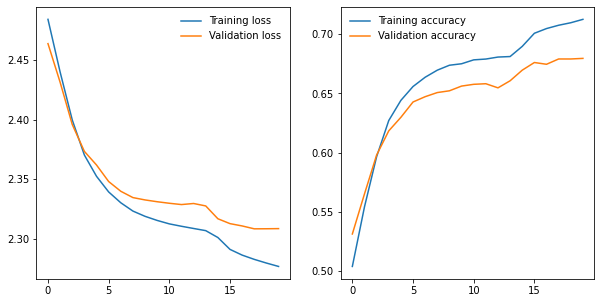

In [122]:
# Plot the training and validation loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_rnn, label='Training loss')
plt.plot(val_losses_rnn, label='Validation loss')
plt.legend(frameon=False)
plt.subplot(1, 2, 2)
plt.plot(train_acc_rnn, label='Training accuracy')
plt.plot(val_acc_rnn, label='Validation accuracy')
plt.legend(frameon=False)
plt.show()

### Performing hyperparameter tuning on the RNN model by varying the learning rate

In [126]:
# Hyperparameter tuning
learning_rates = [1e-4, 0.005, 1e-3, 0.05, 1e-2]
num_epochs = 5
model_list = []
train_losses_tuning = []
train_acc_tuning = []
val_losses_tuning = []
val_acc_tuning = []

In [128]:
for lr in learning_rates:
    rnn = RNN(n_letters, 128, n_categories).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(rnn.parameters(), lr=lr)
    print("Learning rate: ", lr)
    train_losses, train_acc, val_losses, val_acc = train_rnn(rnn, train_data, train_labels, num_epochs)
    print("===============================================================")
    model_list.append((lr, rnn))
    train_losses_tuning.append(train_losses)
    train_acc_tuning.append(train_acc)
    val_losses_tuning.append(val_losses)
    val_acc_tuning.append(val_acc)

Learning rate:  0.0001
Epoch: 1 Train Loss: 2.48714
Epoch: 1 Train Accuracy: 0.50146
Epoch: 1 Val Loss: 2.45945
Epoch: 1 Val Accuracy: 0.53214
Epoch: 2 Train Loss: 2.43158
Epoch: 2 Train Accuracy: 0.56417
Epoch: 2 Val Loss: 2.43161
Epoch: 2 Val Accuracy: 0.55705
Epoch: 3 Train Loss: 2.39533
Epoch: 3 Train Accuracy: 0.59829
Epoch: 3 Val Loss: 2.39702
Epoch: 3 Val Accuracy: 0.59193
Epoch: 4 Train Loss: 2.36909
Epoch: 4 Train Accuracy: 0.62538
Epoch: 4 Val Loss: 2.37484
Epoch: 4 Val Accuracy: 0.61734
Epoch: 5 Train Loss: 2.35375
Epoch: 5 Train Accuracy: 0.63964
Epoch: 5 Val Loss: 2.36110
Epoch: 5 Val Accuracy: 0.62730
Learning rate:  0.005
Epoch: 1 Train Loss: 2.87450
Epoch: 1 Train Accuracy: 0.10717
Epoch: 1 Val Loss: 2.90837
Epoch: 1 Val Accuracy: 0.07324
Epoch: 2 Train Loss: 2.89730
Epoch: 2 Train Accuracy: 0.08425
Epoch: 2 Val Loss: 2.90232
Epoch: 2 Val Accuracy: 0.07922
Epoch: 3 Train Loss: 2.90470
Epoch: 3 Train Accuracy: 0.07684
Epoch: 3 Val Loss: 2.90282
Epoch: 3 Val Accuracy: 0.0

### Results obtained using different learning rates

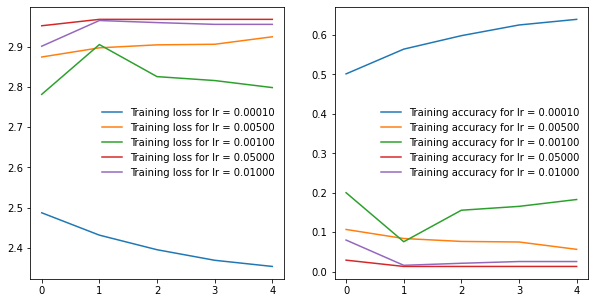

In [129]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for i in range(len(learning_rates)):
    plt.plot(train_losses_tuning[i], label='Training loss for lr = %1.5f' % learning_rates[i])
plt.legend(frameon=False)
plt.subplot(1, 2, 2)
for i in range(len(learning_rates)):
    plt.plot(train_acc_tuning[i], label='Training accuracy for lr = %1.5f' % learning_rates[i])
plt.legend(frameon=False)
plt.show()

We can infer that the model with learning rate as 0.0001 performs the best on the training set.

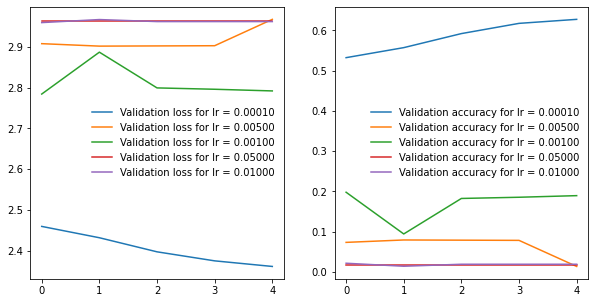

In [130]:
# Plot the validation loss and accuracy for different learning rates
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for i in range(len(learning_rates)):
    plt.plot(val_losses_tuning[i], label='Validation loss for lr = %1.5f' % learning_rates[i])
plt.legend(frameon=False)
plt.subplot(1, 2, 2)
for i in range(len(learning_rates)):
    plt.plot(val_acc_tuning[i], label='Validation accuracy for lr = %1.5f' % learning_rates[i])
plt.legend(frameon=False)
plt.show()

We can infer that the model with learning rate as 0.0001 performs the best on the validation set as well

In [131]:
print(model_list)

[(0.0001, RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): Softmax(dim=1)
)), (0.005, RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): Softmax(dim=1)
)), (0.001, RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): Softmax(dim=1)
)), (0.05, RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): Softmax(dim=1)
)), (0.01, RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): Softmax(dim=1)
))]


### Saving the model with best hyperparameters

In [132]:
torch.save(model_list[0][1].state_dict(), 'rnn_best_1e-4.pt')

### Training the best model on the training set and validating it on the validation set with 30 epochs

In [133]:
# Training the best model for 30 epochs
rnn_best = RNN(n_letters, 128, n_categories).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_best.parameters(), lr=1e-4)
num_epochs = 30
train_losses_rnn_best, train_acc_rnn_best, val_losses_rnn_best, val_acc_rnn_best = train_rnn(rnn_best, train_data, train_labels, num_epochs)

Epoch: 1 Train Loss: 2.48506
Epoch: 1 Train Accuracy: 0.50153
Epoch: 1 Val Loss: 2.46466
Epoch: 1 Val Accuracy: 0.53264
Epoch: 2 Train Loss: 2.43236
Epoch: 2 Train Accuracy: 0.56205
Epoch: 2 Val Loss: 2.44304
Epoch: 2 Val Accuracy: 0.54260
Epoch: 3 Train Loss: 2.40209
Epoch: 3 Train Accuracy: 0.58659
Epoch: 3 Val Loss: 2.41545
Epoch: 3 Val Accuracy: 0.57150
Epoch: 4 Train Loss: 2.38778
Epoch: 4 Train Accuracy: 0.60384
Epoch: 4 Val Loss: 2.39590
Epoch: 4 Val Accuracy: 0.59043
Epoch: 5 Train Loss: 2.36959
Epoch: 5 Train Accuracy: 0.62420
Epoch: 5 Val Loss: 2.37614
Epoch: 5 Val Accuracy: 0.61485
Epoch: 6 Train Loss: 2.35373
Epoch: 6 Train Accuracy: 0.64089
Epoch: 6 Val Loss: 2.36214
Epoch: 6 Val Accuracy: 0.62980
Epoch: 7 Train Loss: 2.34058
Epoch: 7 Train Accuracy: 0.65571
Epoch: 7 Val Loss: 2.34952
Epoch: 7 Val Accuracy: 0.63976
Epoch: 8 Train Loss: 2.33015
Epoch: 8 Train Accuracy: 0.66505
Epoch: 8 Val Loss: 2.34190
Epoch: 8 Val Accuracy: 0.64375
Epoch: 9 Train Loss: 2.32365
Epoch: 9 Tr

### Plotting the training and validation loss and accuracy for the best model

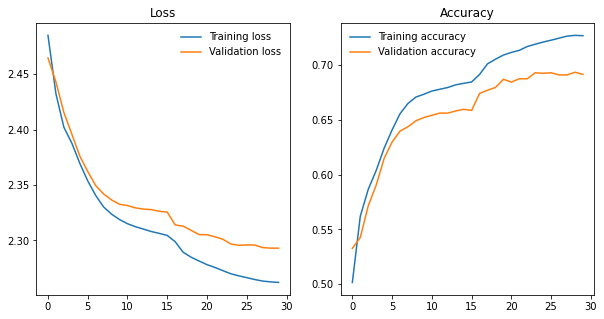

In [159]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_rnn_best, label='Training loss')
plt.plot(val_losses_rnn_best, label='Validation loss')
plt.title('Loss')
plt.legend(frameon=False)
plt.subplot(1, 2, 2)
plt.plot(train_acc_rnn_best, label='Training accuracy')
plt.plot(val_acc_rnn_best, label='Validation accuracy')
plt.title('Accuracy')
plt.legend(frameon=False)
plt.show()

### Save the best model trained on 30 epochs

In [134]:
torch.save(rnn_best.state_dict(), 'rnn_best_30_epochs.pt')

### Obtaining a confusion matrix for the best model

In [135]:
def get_confusion_matrix(model, data, labels):
    confusion_matrix = np.zeros((n_categories, n_categories))
    for i in range(len(data)):
        input = data[i].to(device)
        target = torch.tensor([labels[i]], dtype=torch.long).to(device)
        hidden = model.initHidden().to(device)
        for j in range(input.size()[0]):
            output, hidden = model(input[j], hidden)
        confusion_matrix[labels[i]][torch.argmax(output)] += 1
    return confusion_matrix

confusion_matrix = get_confusion_matrix(rnn_best, val_data, val_labels)

### Plotting the confusion matrix as a heatmap for the best model

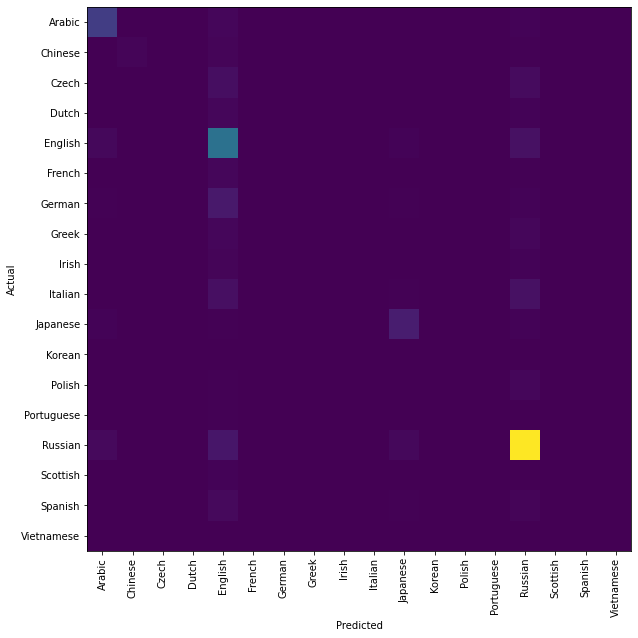

In [138]:
plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix)
plt.xticks(np.arange(n_categories), all_categories, rotation=90)
plt.yticks(np.arange(n_categories), all_categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Adding three more linear layers to our current RNN architecture. All the three layers have 128 hidden units and ReLU activation function

In [141]:
class RNN_updated(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_updated, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h1 = nn.Linear(hidden_size, hidden_size)  
        self.h2 = nn.Linear(hidden_size, hidden_size)
        self.h3 = nn.Linear(hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        hidden = self.relu(hidden)
        hidden = self.h1(hidden)
        hidden = self.relu(hidden)
        hidden = self.h2(hidden)
        hidden = self.relu(hidden)
        hidden = self.h3(hidden)
        hidden = self.relu(hidden)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

### Instantiating the RNN model with the updated architecture

In [142]:
rnn_updated = RNN_updated(n_letters, 128, n_categories).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_updated.parameters(), lr=1e-4)
num_epochs = 30
train_losses_rnn_updated, train_acc_rnn_updated, val_losses_rnn_updated, val_acc_rnn_updated = train_rnn(rnn_updated, train_data, train_labels, num_epochs)

Epoch: 1 Train Loss: 2.50092
Epoch: 1 Train Accuracy: 0.47606
Epoch: 1 Val Loss: 2.48863
Epoch: 1 Val Accuracy: 0.48530
Epoch: 2 Train Loss: 2.47187
Epoch: 2 Train Accuracy: 0.53310
Epoch: 2 Val Loss: 2.46454
Epoch: 2 Val Accuracy: 0.53513
Epoch: 3 Train Loss: 2.44737
Epoch: 3 Train Accuracy: 0.55589
Epoch: 3 Val Loss: 2.43925
Epoch: 3 Val Accuracy: 0.57698
Epoch: 4 Train Loss: 2.43700
Epoch: 4 Train Accuracy: 0.56604
Epoch: 4 Val Loss: 2.43996
Epoch: 4 Val Accuracy: 0.55406
Epoch: 5 Train Loss: 2.41313
Epoch: 5 Train Accuracy: 0.59014
Epoch: 5 Val Loss: 2.40165
Epoch: 5 Val Accuracy: 0.60040
Epoch: 6 Train Loss: 2.39235
Epoch: 6 Train Accuracy: 0.60651
Epoch: 6 Val Loss: 2.38533
Epoch: 6 Val Accuracy: 0.61236
Epoch: 7 Train Loss: 2.36898
Epoch: 7 Train Accuracy: 0.62656
Epoch: 7 Val Loss: 2.36281
Epoch: 7 Val Accuracy: 0.62681
Epoch: 8 Train Loss: 2.35571
Epoch: 8 Train Accuracy: 0.63796
Epoch: 8 Val Loss: 2.35954
Epoch: 8 Val Accuracy: 0.63328
Epoch: 9 Train Loss: 2.34567
Epoch: 9 Tr

### Save the best model trained on 30 epochs with updated architecture

In [143]:
torch.save(rnn_updated.state_dict(), 'rnn_updated_best_1e-4.pt')

### Plotting the training and validation loss and accuracy for the updated model

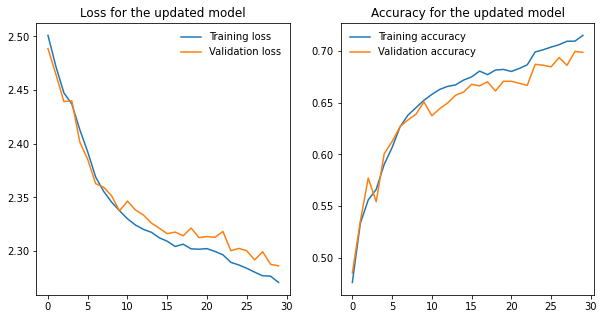

In [145]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_rnn_updated, label='Training loss')
plt.plot(val_losses_rnn_updated, label='Validation loss')
plt.title('Loss for the updated model')
plt.legend(frameon=False)
plt.subplot(1, 2, 2)
plt.plot(train_acc_rnn_updated, label='Training accuracy')
plt.plot(val_acc_rnn_updated, label='Validation accuracy')
plt.title('Accuracy for the updated model')
plt.legend(frameon=False)
plt.show()

### Obtaining a confusion matrix for the updated model

In [160]:
confusion_matrix_updated = get_confusion_matrix(rnn_updated, val_data, val_labels)

### Plotting the confusion matrix as a heatmap for the updated model

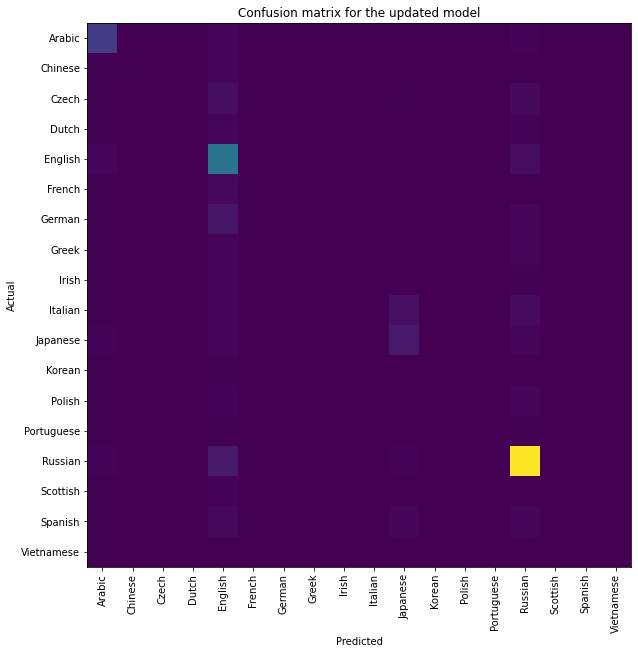

In [161]:
plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix_updated)
plt.xticks(np.arange(n_categories), all_categories, rotation=90)
plt.yticks(np.arange(n_categories), all_categories)
plt.title('Confusion matrix for the updated model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Testing the original and updated models on the test set

In [146]:
def test_rnn(model, data, labels):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in range(len(data)):
            input = data[i].to(device)
            target = torch.tensor([labels[i]], dtype=torch.long).to(device)
            hidden = model.initHidden().to(device)
            for j in range(input.size()[0]):
                output, hidden = model(input[j], hidden)
            if torch.argmax(output) == target:
                correct += 1
            total += 1
    print('Accuracy of the model on the test set: %d %%' % (100 * correct / total))
    return correct / total

### Getting test accuracy for the original model

In [147]:
test_acc_rnn_original = test_rnn(rnn_best, test_data, test_labels)

Accuracy of the model on the test set: 70 %


### Getting test accuracy for the updated model

In [148]:
test_acc_rnn_updated = test_rnn(rnn_updated, test_data, test_labels)

Accuracy of the model on the test set: 69 %


### Build a stacked RNN (2 RNN blocks) model using the same original architecture as above

In [149]:
class StackedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StackedRNN, self).__init__()
        self.rnn1 = RNN(input_size, hidden_size, hidden_size)
        self.rnn2 = RNN(hidden_size, hidden_size, output_size)

    def forward(self, input, hidden1, hidden2):
        output1, hidden1 = self.rnn1(input, hidden1)
        output2, hidden2 = self.rnn2(output1, hidden2)
        return output2, hidden1, hidden2

    def initHidden(self, batch_size):
        hidden1 = self.rnn1.initHidden().expand(batch_size, -1).clone()
        hidden2 = self.rnn2.initHidden().expand(batch_size, -1).clone()
        return hidden1, hidden2

### Defining the training loop for the stacked RNN model

In [156]:
def train_rnn_stacked(rnn, train_data, train_labels, num_epochs):
    train_losses = []
    train_acc = []
    val_losses = []
    val_acc = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_acc = 0.0
        rnn.train()
        for i in range(len(train_data)):
            input = train_data[i].to(device)
            target = torch.tensor([train_labels[i]], dtype=torch.long).to(device)
            hidden1, hidden2 = rnn.initHidden(1)
            hidden1 = hidden1.to(device)
            hidden2 = hidden2.to(device)
            optimizer.zero_grad()
            for j in range(input.size()[0]):
                output, hidden1, hidden2 = rnn(input[j], hidden1, hidden2)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_acc += torch.argmax(output) == target
        train_losses.append(running_loss / len(train_data))
        train_acc.append(running_acc / len(train_data))
        print('Epoch %d/%d, Training Loss: %.4f, Training Accuracy: %.4f' % (epoch+1, num_epochs, train_losses[-1], train_acc[-1]))

        running_loss_val = 0.0
        running_acc_val = 0.0
        for i in range(len(val_data)):
            input = val_data[i].to(device)
            target = torch.tensor([val_labels[i]], dtype=torch.long).to(device)
            hidden1, hidden2 = rnn.initHidden(1)
            hidden1 = hidden1.to(device)
            hidden2 = hidden2.to(device)
            for j in range(input.size()[0]):
                output, hidden1, hidden2 = rnn(input[j], hidden1, hidden2)
            loss = criterion(output, target)
            running_loss_val += loss.item()
            running_acc_val += torch.argmax(output) == target
        val_losses.append(running_loss_val / len(val_data))
        val_acc.append(running_acc_val / len(val_data))
        print('Epoch %d/%d, Validation Loss: %.4f, Validation Accuracy: %.4f' % (epoch+1, num_epochs, val_losses[-1], val_acc[-1]))
    return train_losses, train_acc, val_losses, val_acc

### Performing hyperparameter tuning for the stacked RNN model by varying the learning rate

In [157]:
lr_stacked_rnn = [1e-2, 1e-3, 1e-4, 1e-5]
num_epochs = 10
model_list_stacked_rnn = []
train_losses_tuning_stacked_rnn = []
val_losses_tuning_stacked_rnn = []
train_acc_tuning_stacked_rnn = []
val_acc_tuning_stacked_rnn = []

In [158]:
for lr in lr_stacked_rnn:
    stacked_rnn = StackedRNN(n_letters, 128, n_categories).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(stacked_rnn.parameters(), lr=lr)
    print('Learning rate: ', lr)
    train_losses_stacked_rnn, train_acc_stacked_rnn, val_losses_stacked_rnn, val_acc_stacked_rnn = train_rnn_stacked(stacked_rnn, train_data, train_labels, num_epochs)
    print("============================================================")
    model_list_stacked_rnn.append(stacked_rnn)
    train_losses_tuning_stacked_rnn.append(train_losses_stacked_rnn)
    val_losses_tuning_stacked_rnn.append(val_losses_stacked_rnn)
    train_acc_tuning_stacked_rnn.append(train_acc_stacked_rnn)
    val_acc_tuning_stacked_rnn.append(val_acc_stacked_rnn)

Learning rate:  0.01
Epoch 1/10, Training Loss: 2.8893, Training Accuracy: 0.0923
Epoch 1/10, Validation Loss: 2.9776, Validation Accuracy: 0.0040
Epoch 2/10, Training Loss: 2.9766, Training Accuracy: 0.0050
Epoch 2/10, Validation Loss: 2.9776, Validation Accuracy: 0.0040
Epoch 3/10, Training Loss: 2.9764, Training Accuracy: 0.0051
Epoch 3/10, Validation Loss: 2.9776, Validation Accuracy: 0.0040
Epoch 4/10, Training Loss: 2.9763, Training Accuracy: 0.0052
Epoch 4/10, Validation Loss: 2.9776, Validation Accuracy: 0.0040
Epoch 5/10, Training Loss: 2.9763, Training Accuracy: 0.0052
Epoch 5/10, Validation Loss: 2.9776, Validation Accuracy: 0.0040
Epoch 6/10, Training Loss: 2.9763, Training Accuracy: 0.0052
Epoch 6/10, Validation Loss: 2.9776, Validation Accuracy: 0.0040
Epoch 7/10, Training Loss: 2.9763, Training Accuracy: 0.0052
Epoch 7/10, Validation Loss: 2.9776, Validation Accuracy: 0.0040
Epoch 8/10, Training Loss: 2.9763, Training Accuracy: 0.0052
Epoch 8/10, Validation Loss: 2.9776,

### Saving the stacked RNN model with best hyperparameters

In [175]:
torch.save(model_list_stacked_rnn[2], 'stacked_rnn_best_1e-4.pt')

### Plottting the training loss and validation loss for the stacked RNN model

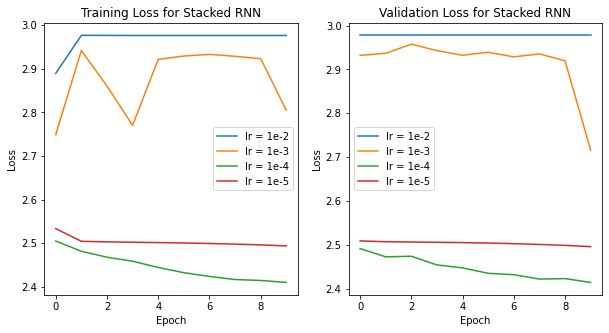

In [162]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_tuning_stacked_rnn[0], label='lr = 1e-2')
plt.plot(train_losses_tuning_stacked_rnn[1], label='lr = 1e-3')
plt.plot(train_losses_tuning_stacked_rnn[2], label='lr = 1e-4')
plt.plot(train_losses_tuning_stacked_rnn[3], label='lr = 1e-5')
plt.legend()
plt.title('Training Loss for Stacked RNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(val_losses_tuning_stacked_rnn[0], label='lr = 1e-2')
plt.plot(val_losses_tuning_stacked_rnn[1], label='lr = 1e-3')
plt.plot(val_losses_tuning_stacked_rnn[2], label='lr = 1e-4')
plt.plot(val_losses_tuning_stacked_rnn[3], label='lr = 1e-5')
plt.legend()
plt.title('Validation Loss for Stacked RNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [167]:
words = ['Emilia', 'Alexandra', 'Sachiko', 'Vladimir', 'Minh', 'Xi', 'Muammar', 'Mukesh', 'Andrew', 'Ronaldo']

### Predicting the language of origin of the words list using the original RNN best model

In [168]:
def predict_rnn(rnn, word):
    rnn.eval()
    with torch.no_grad():
        input = lineToTensor(word).to(device)
        hidden = rnn.initHidden().to(device)
        for j in range(input.size()[0]):
            output, hidden = rnn(input[j], hidden)

        predcited = torch.argmax(output)
        return all_categories[predcited]

In [170]:
for word in words:
    print(word, "==", predict_rnn(rnn_best, word))

Emilia == Russian
Alexandra == English
Sachiko == Japanese
Vladimir == Russian
Minh == English
Xi == Korean
Muammar == Arabic
Mukesh == Japanese
Andrew == English
Ronaldo == English


### Predicting the language of origin of the words list using the updated RNN best model

In [171]:
def predict_rnn_updated(rnn, word):
    rnn.eval()
    with torch.no_grad():
        input = lineToTensor(word).to(device)
        hidden = rnn.initHidden().to(device)
        for j in range(input.size()[0]):
            output, hidden = rnn(input[j], hidden)

        predcited = torch.argmax(output)
        return all_categories[predcited]

In [173]:
for word in words:
    print(word, "==",  predict_rnn_updated(rnn_updated, word))

Emilia == Russian
Alexandra == Japanese
Sachiko == Russian
Vladimir == Russian
Minh == English
Xi == Chinese
Muammar == Russian
Mukesh == Russian
Andrew == English
Ronaldo == Russian


### Predicting the language of origin of the words list using the stacked RNN best model

In [177]:
def predict_stack_rnn(rnn, word):
    rnn.eval()
    with torch.no_grad():
        input = lineToTensor(word).to(device)
        hidden1, hidden2 = rnn.initHidden(1)
        hidden1 = hidden1.to(device)
        hidden2 = hidden2.to(device)
        for j in range(input.size()[0]):
            output, hidden1, hidden2 = rnn(input[j], hidden1, hidden2)

        predicted = torch.argmax(output)
        return all_categories[predicted]

In [179]:
for word in words:
    print(word, "==", predict_stack_rnn(model_list_stacked_rnn[2], word))

Emilia == Russian
Alexandra == Russian
Sachiko == Arabic
Vladimir == Russian
Minh == English
Xi == Chinese
Muammar == Russian
Mukesh == Russian
Andrew == English
Ronaldo == English


**END OF LAB**

---